In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from keplergl import KeplerGl
import math
%matplotlib inline
from io import BytesIO
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg

In [32]:
provincedf=pd.read_csv('data/migration_0220.csv')
pop=pd.read_csv('data/province_population.csv')
pop=pop[:31].sort_values('province_cn')
provincedf.from_province.unique()

array(['上海', '云南', '内蒙古自治区', '北京', '吉林', '四川', '天津', '宁夏回族自治区', '安徽',
       '山东', '山西', '广东', '广西壮族自治区', '新疆维吾尔自治区', '江苏', '江西', '河北', '河南',
       '浙江', '海南', '湖北', '湖南', '甘肃', '福建', '西藏自治区', '贵州', '辽宁', '重庆',
       '陕西', '青海', '黑龙江'], dtype=object)

### 1. Construct OD matrix(Note: data is not real)

In [4]:
# here we use day of Jan. 15 as the Chunyun data
oneday_mobility=provincedf[provincedf['time']=='2020-01-15']

oneday_mobility=oneday_mobility.drop_duplicates(subset=['from_province','to_province'])

OD_matrix=oneday_mobility.pivot(index='from_province',columns='to_province',values='quantity')
OD_simulate=OD_matrix.interpolate()
#remove the interpolation of city to itselves
OD_simulateDF=pd.DataFrame(OD_simulate.stack(), columns=['quantity']).reset_index()
OD_simulateDF=OD_simulateDF[OD_simulateDF['from_province']!=OD_simulateDF['to_province']]
OD_matrixDF=OD_simulateDF.pivot(index='from_province',columns='to_province',values='quantity')
OD_matrixDF.fillna(0,inplace=True)

### 2. SEIR Model

In [17]:
#Parameter β represents the rate of conversion from “susceptable” to “exposed”
beta= 0.625
#from "exposed" to "infected" with a rate of α: alpha
alpha=1/7 #This could change per serious of the disease

#Parameter γ determines the rate of recovery, 
#while the recovered subjects are removed from the repository of susceptible subjects. y for gamma
gamma= 0.135

R0=beta/gamma

mobility_factor=1 #adjust this to control inflow out flow
max_hospital=10000# assume 10000 people could be in hospital
Nc=pop['pop_18_m'].values.T
R0

4.62962962962963

In [9]:
def translate(df):
    df=df.merge(pop, left_on='province',right_on='province_cn',how='left')
    return df

In [12]:
new_df = pd.DataFrame({'湖北': np.zeros(31)})
def update_mobility(matrix,stop_province='湖北',mobility_fc=0.7):
    '''This function update the mobility matrix after the day Hubei was isolated.
    matri: current OD matrix
    stop_province: it is Hubei by default for this time
    mobility_fc: percentage of default value; assume that mobility between other city will also decrease'''
    
    newmatrix=matrix.copy()*mobility_fc
    newmatrix[stop_province]=0
    newmatrix.loc[stop_province,:]=0
    
    return newmatrix
newmatrix=update_mobility(OD_matrixDF,stop_province='湖北',mobility_fc=0.7)


In [18]:
def SEIR_Model(seir,OD_matrixDF):
    '''Typical SEIR Model'''
    seir_previous=seir.copy()
    flow_infected_matrix=OD_matrixDF*mobility_factor/Nc * seir_previous[:,2]
    inflow_infected_sum=flow_infected_matrix.sum(axis=1)
    total_infected=seir_previous[:,2]+inflow_infected_sum
    
    new_S=-1*beta*(total_infected)*seir_previous[:,0]/Nc
    new_E=beta*(total_infected)*seir_previous[:,0]/Nc - alpha* seir_previous[:,1]
    new_I = alpha*seir_previous[:,1] - gamma*seir_previous[:,2]
    new_R = gamma*seir_previous[:,2] 
    
    seir[:,0]=seir[:,0]+new_S
    seir[:,1]=seir[:,1]+new_E
    seir[:,2]=seir[:,2]+new_I
    seir[:,3]=seir[:,3]+new_R
    
    return seir

In [15]:
pop['pop_18_m'].values

array([ 24240000,  48300000,  25340000,  21540000,  27040000,  83410000,
        15600000,   6880000,  63240000, 100470000,  37180000, 113460000,
        49260000,  24870000,  80510000,  46480000,  75560000,  96050000,
        57370000,   9340000,  59170000,  68990000,  26370000,  39410000,
         3440000,  36000000,  43590000,  31020000,  38640000,   6030000,
        37730000])

In [19]:
# This process didn't consider individual quanrantine, only includes Hubei's city level quanrantine
def run(OD_matrix,beta, gamma, alpha,quarantine_start=62,T=300,quarantine=True):
    "this function run the SEIR model using the pre-definde parameter"

    #innitiate initial#population of different province
    SEIR=np.zeros([len(pop.province_cn.unique()),4])
    SEIR[:,0]=Nc
    first_exposed=np.where(SEIR[:, 0]==59170000,1,0)#this is to find Hubei Province's index
    SEIR[:, 0] = SEIR[:, 0] - first_exposed # suscepticles -1
    SEIR[:, 1] = SEIR[:, 1] + first_exposed #
    SEIR[:, 2] = SEIR[:, 2] + first_exposed*alpha# move infections to the I group


    
    output=pd.DataFrame({"day":[],"province":[],"susceptics":[],"exposed":[],"infected":[],"recover":[]})
    provincelist=pop.province_cn.unique()
    OD_matrix_norm=OD_matrix.copy()
    OD_matrix_update=update_mobility(OD_matrix,stop_province='湖北',mobility_fc=0.7)
    
    if not quarantine:
        for i in range(T):
            SEIR=SEIR_Model(SEIR,OD_matrix)
            day=np.full(len(provincelist),i)
            new=pd.DataFrame({"day":day,"province":provincelist,"susceptics": SEIR[:,0],
                          "exposed": SEIR[:,1],"infected": SEIR[:,2],"recover": SEIR[:,3]})
            output=pd.concat([output,new], sort=False)
    else:
        for i in range(T):
            if i<quarantine_start:
                SEIR=SEIR_Model(SEIR,OD_matrix_norm)

            else:
                SEIR=SEIR_Model(SEIR,OD_matrix_update)
            day=np.full(len(provincelist),i)
            new=pd.DataFrame({"day":day,"province":provincelist,"susceptics": SEIR[:,0],
                          "exposed": SEIR[:,1],"infected": SEIR[:,2],"recover": SEIR[:,3]})
            output=pd.concat([output,new], sort=False)
            
                
    output=translate(output)
    output.day=output.day.astype(int)
    return output

output=run(OD_matrixDF, beta, gamma, alpha,quarantine_start=62,T=300,quarantine=False)#no quarantine

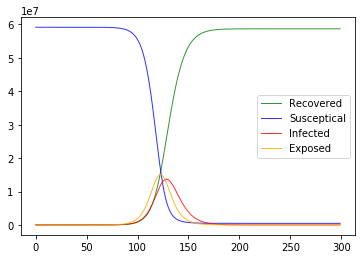

In [20]:
sh=output[output['province_en']=='Hubei']
plt.plot(sh['day'],sh['recover'], marker='', color='green', linewidth=1, alpha=0.8, label='Recovered')
plt.plot(sh['day'],sh['susceptics'], marker='', color='blue', linewidth=1, alpha=0.8, label='Susceptical')
plt.plot(sh['day'],sh['infected'], marker='', color='red', linewidth=1, alpha=0.8, label='Infected')
plt.plot(sh['day'],sh['exposed'], marker='', color='orange', linewidth=1, alpha=0.8, label='Exposed')
plt.legend()

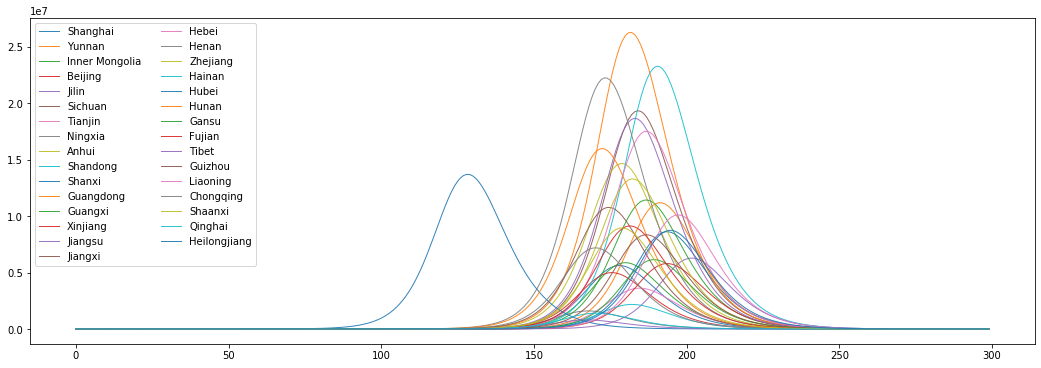

In [21]:
def plotall_province(output,periods):
    #this function plot all provinces simulation.
    output2=output[output['day']<periods]
    fig=plt.figure(figsize=(18,6))
    for i, province in enumerate(output2['province_en'].unique()):
        df=output2[output2['province_en']==province]
        plt.plot(df['day'], df['infected'], marker='', linewidth=1, alpha=0.9, label=province)
    plt.legend(loc=2, ncol=2)
plotall_province(output,300)

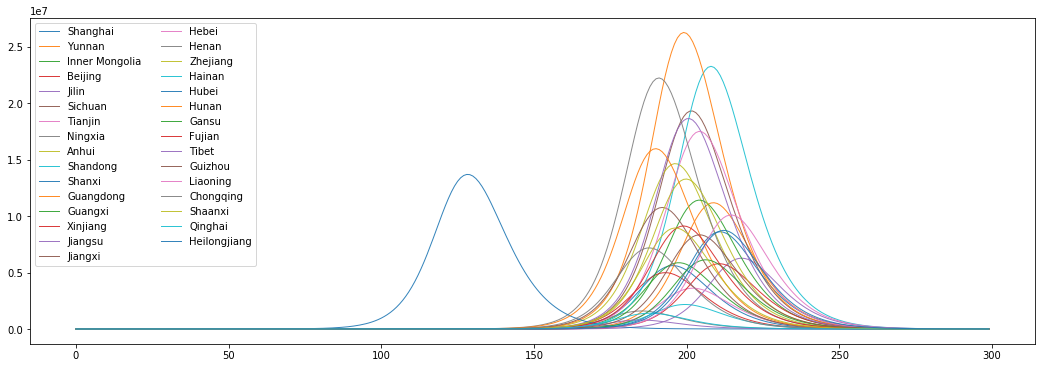

In [22]:
#show Quarantine at day 10 after the first infected person in Hubei
output_q=run(OD_matrixDF, beta, gamma, alpha,quarantine_start=10,T=300,quarantine=True)
plotall_province(output_q,300)
#the results show every province's peak time pushed by about 30 days

### This is for you to try:

In [27]:
#change quarantine_start date and visualize the difference
start_date=20 # default value

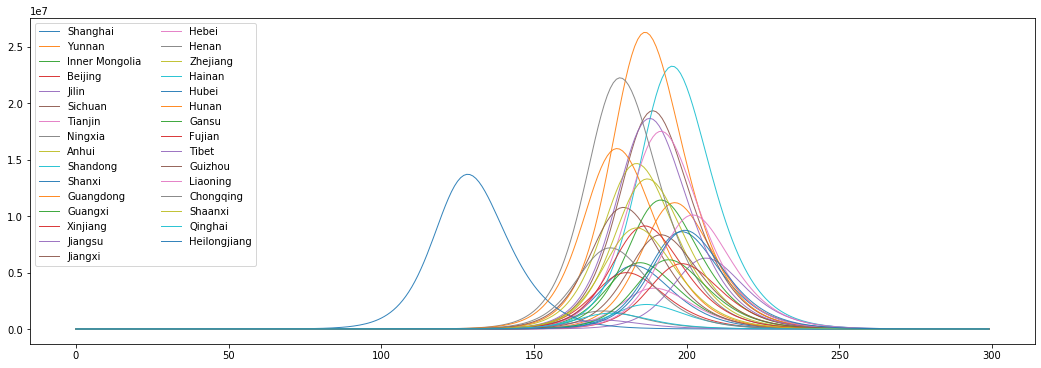

In [23]:
#show Quarantine at day 60 after the first infected person in Hubei
output_q60=run(OD_matrixDF, beta, gamma, alpha,quarantine_start=start_date,T=300,quarantine=True)
plotall_province(output_q60,300)
#the results show every province's peak time pushed by about 30 days

Text(0.5, 1.0, "Simulation of Beijing Number of Infected people from the first day of Hubei's infection to the 100th day")

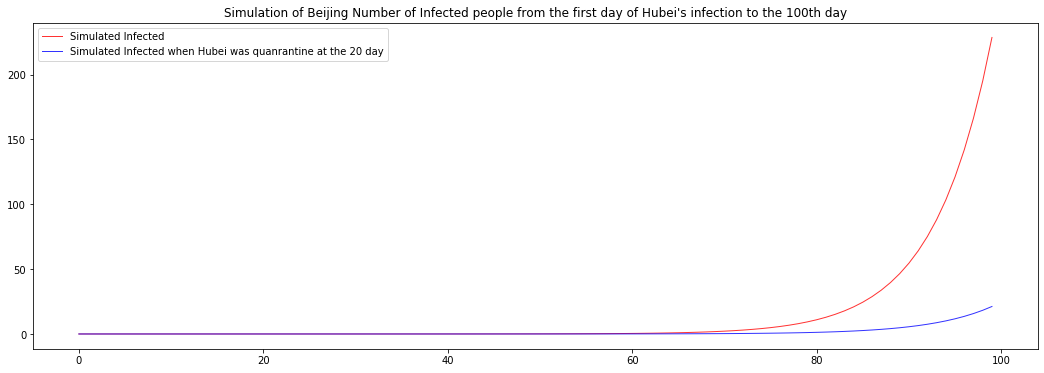

In [29]:
def plotsingleprovince(province_name,day,start_date):
    bj=output[output['province_en']==province_name][:day]
    bj_q=output_q[output_q['province_en']==province_name][:day]
    fig=plt.figure(figsize=(18,6))
    plt.plot(bj['day'],bj['infected'],marker='',color='red',linewidth=1, 
             alpha=0.8,label='Simulated Infected')
    plt.plot(bj_q['day'],bj_q['infected'],marker='',color='blue',linewidth=1, 
             alpha=0.8,label='Simulated Infected when Hubei was quanrantine at the {} day'.format(start_date))
    plt.legend()
    
plotsingleprovince('Beijing',100,start_date)
plt.title("Simulation of Beijing Number of Infected people from the first day of Hubei's infection to the 100th day")

### 4. File to csv/json

In [ ]:
output_q60.to_csv('### anyname you like.csv')